In [2]:
import nltk as nl
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

stop = set()

flag =1
inFile = open("./stoplist.txt","r")
while flag == 1:
    line = inFile.readline()
    if line == "":
        flag = 0
    stop.add(line[:-1])
inFile.close()
#GET THE TRAINING DATA PRE-PROCESSED
big = pd.read_csv('big_train.csv')
medium = pd.read_csv('medium_train.csv') 
small = pd.read_csv('small_train.csv')
tiny = pd.read_csv('tiny_train.csv')

def clean_data(df):
    comments =[]
    tags={}
    vocablist={}
    for i in range(len(df)):
        tag = df.iloc[i, 2] or df.iloc[i, 3] or df.iloc[i, 4] or df.iloc[i, 5] or df.iloc[i, 6] or df.iloc[i, 7]
        tokens = nl.regexp_tokenize(df.iloc[i, 1], r'[,\.\?\n\t0123456789 •/\'><;\|:·[\]{}+-=_()!@#$%^&*~`"]\s*', gaps=True)
        tokens = [token.lower() for token in tokens]
        reduced = set()
        for word in tokens:
            if word not in stop:
                reduced.add(word)
                if word not in vocablist.keys():
                    vocablist[word] = 1
                else:
                    vocablist[word]+=1
        un_token = TreebankWordDetokenizer() 
        comments.append(un_token.detokenize(reduced))
        tags[i] = tag
    return comments, tags

#big DATASET
comments, tags = clean_data(big) 
count_vector = CountVectorizer() 
dataframe = count_vector.fit_transform(comments)
bag_o_words = dataframe.toarray()
features = count_vector.get_feature_names_out()

X = bag_o_words
Y = pd.DataFrame(list(tags.values()))[0]

bigx_train, x_test, bigy_train, y_test = train_test_split(X, Y, test_size=0.3)
nb = MultinomialNB().fit(bigx_train,bigy_train)
prediction = nb.predict(x_test)
nb_large_accuracy = accuracy_score(y_test, prediction)

#code for probability that a word is most likely in a toxic or non_toxic comment:
#code found on https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
not_toxic = nb.feature_log_prob_[0, :].argsort()[::-1]
toxic = nb.feature_log_prob_[1, :].argsort()[::-1]
print(np.take(count_vector.get_feature_names_out(), not_toxic[:10]))
print(np.take(count_vector.get_feature_names_out(), toxic[:10]))


lr = LogisticRegression()
lr.fit(bigx_train, bigy_train)
predict = lr.predict(x_test)
lr_large_accuracy = accuracy_score(y_test, predict)

#MEDIUM DATASET
comments, tags = clean_data(medium)
count_vector = CountVectorizer()
dataframe = count_vector.fit_transform(comments)
bag_o_words = dataframe.toarray()
features = count_vector.get_feature_names_out()

#Begin creating Naive Bayes
X = bag_o_words
Y = pd.DataFrame(list(tags.values()))[0]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
nb = MultinomialNB().fit(x_train,y_train)
prediction = nb.predict(x_test)
nb_medium_accuracy = accuracy_score(y_test, prediction)

lr = LogisticRegression()
lr.fit(x_train, y_train)
predict = lr.predict(x_test)
lr__medium_accuracy = accuracy_score(y_test, predict)

#small train and test
comments, tags = clean_data(small)
count_vector = CountVectorizer()
dataframe = count_vector.fit_transform(comments)
# pd.DataFrame(dataframe.toarray(), columns = count_vector.get_feature_names_out())
bag_o_words = dataframe.toarray()
features = count_vector.get_feature_names_out()


#Begin creating Naive Bayes
X = bag_o_words
Y = pd.DataFrame(list(tags.values()))[0]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
nb = MultinomialNB().fit(x_train, y_train)
prediction = nb.predict(x_test)
nb_small_accuracy = accuracy_score(y_test, prediction)

lr = LogisticRegression().fit(x_train, y_train)
predict = lr.predict(x_test)
lr_small_accuracy = accuracy_score(y_test, predict)

#NOW DO THE SAME FOR TINY
comments, tags = clean_data(tiny)
count_vector = CountVectorizer()
dataframe = count_vector.fit_transform(comments)
bag_o_words = dataframe.toarray()
features = count_vector.get_feature_names_out()

#Begin creating Naive Bayes
X = bag_o_words
Y = pd.DataFrame(list(tags.values()))[0]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
nb = MultinomialNB().fit(x_train, y_train)
prediction = nb.predict(x_test)
nb_tiny_accuracy = accuracy_score(y_test, prediction)

#Logistic
lr = LogisticRegression()
lr.fit(x_train, y_train)
predict = lr.predict(x_test)
lr_tiny_accuracy = accuracy_score(y_test, predict)


['article' 'page' 'talk' 'edit' 'time' 'people' 'articles' 'good' 'make'
 'made']
['fuck' 'fucking' 'people' 'page' 'shit' 'stop' 'talk' 'life' 'edit'
 'article']


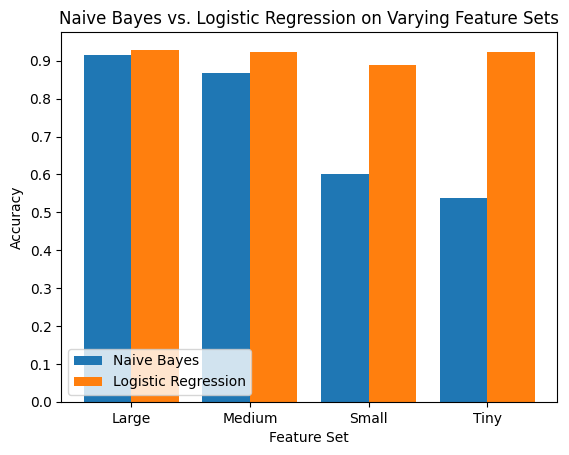

In [30]:
#BAR GRAPH

width = 0.4
df = pd.DataFrame.from_dict({'Size': ['Large', 'Medium', 'Small', 'Tiny'],
                             'NB_Accuracy': [nb_large_accuracy, nb_medium_accuracy, nb_small_accuracy, nb_tiny_accuracy],
                             'LR_Accuracy': [lr_large_accuracy, lr__medium_accuracy, lr_small_accuracy, lr_tiny_accuracy]})
colors = ['blue', 'blue', 'blue', 'blue', 'green', 'green', 'green', 'green']
x_axis = np.arange(len(df['Size']))
plt.bar(x_axis - 0.2, height=df['NB_Accuracy'], width=width, label='Naive Bayes')
plt.bar(x_axis + 0.2, height=df['LR_Accuracy'], width=width, label = 'Logistic Regression')
plt.xticks(x_axis, df['Size'])
plt.yticks(np.arange(0, 1, step=0.1))
plt.title("Naive Bayes vs. Logistic Regression on Varying Feature Sets")
plt.xlabel("Feature Set")
plt.ylabel("Accuracy")
plt.legend(loc='lower left')


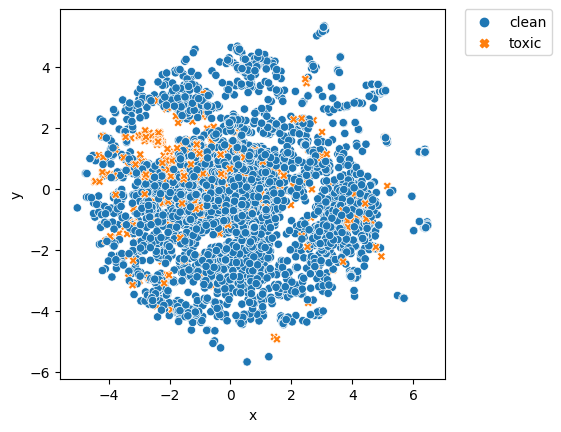

In [3]:
#TSNE PLOT
tsne = TSNE(n_components=2, perplexity=60)
tsne_result = tsne.fit_transform(bigx_train)

bigy_train = bigy_train.replace(1, "toxic")
bigy_train = bigy_train.replace(0, "clean")
tsne_result_df = pd.DataFrame(
    {'x': tsne_result[:, 0], 'y': tsne_result[:, 1], 'label': bigy_train})
fig, ax = plt.subplots(1)
sns.scatterplot(x='x', y='y', hue='label', style='label',
                data=tsne_result_df, ax=ax)
lim = (-10, 10)
ax.set_xlim(auto=1)
ax.set_ylim(auto=1)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
